# CPSC 330 - Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication
### Associated lectures: Lectures 17, 19, 20, and ML communication 

**Due date: April 12, 2022 at 11:59pm**

## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 17, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads the word vectors trained on Wikipedia using an algorithm called Glove. You'll need `gensim` package for that in your cpsc330 conda environment. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [2]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the embeddings. 

**Your tasks:**

1. Calculate the cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [5]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]

In [6]:
for pair in word_pairs:
    print(f"The cosine similarity for {pair[0]} and {pair[1]} is {glove_wiki_vectors.similarity(pair[0], pair[1])}")

The cosine similarity for coast and shore is 0.7000272274017334
The cosine similarity for clothes and closet is 0.5462759733200073
The cosine similarity for old and new is 0.6432487964630127
The cosine similarity for smart and intelligent is 0.7552732229232788
The cosine similarity for dog and cat is 0.8798074722290039
The cosine similarity for tree and lawyer is 0.07671945542097092


The similarities showed do seem to make sense overall, though "clothes" and "closet" is less than I expected.

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 17 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using a dump of Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class with GloVe Wikipedia embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in the embeddings. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use embeddings in your models. 

In [7]:
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    print("%s : %s :: %s : ?" % (word1, word2, word3))
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    return pd.DataFrame(sim_words, columns=["Analogy word", "Score"])

An example of using similarity between words to explore biases and stereotypes.  

In [8]:
glove_wiki_vectors.similarity("white", "rich")

0.447236

In [9]:
glove_wiki_vectors.similarity("black", "rich")

0.5174519

An example of how a model's bias might cause harm in the real world might be auto-moderating chats and/or social media. Granted, this won't ruin lives (probably) but if there's bias that associates certain sensitive topics that tend to be targeted with hate speech with negativity, the messages could get automatically removed and it could silence discussions on topics that need more understanding and awareness.

In [10]:
analogy("men", "worker", "women")

men : worker :: women : ?


,Analogy word,Score
0,workers,0.646628
1,employee,0.636054
2,migrant,0.632769
3,welfare,0.624234
4,labor,0.622042
5,care,0.614134
6,nurse,0.604661
7,employment,0.602174
8,employer,0.593618
9,health,0.588980


In [11]:
analogy("women", "worker", "men")

women : worker :: men : ?


,Analogy word,Score
0,employee,0.711433
1,workers,0.674372
2,soldier,0.644623
3,policeman,0.630179
4,man,0.629005
5,officer,0.619300
6,farmer,0.616310
7,laborer,0.614659
8,truck,0.612763
9,mechanic,0.605399


In [12]:
analogy("poor", "person", "rich")

poor : person :: rich : ?


,Analogy word,Score
0,man,0.592058
1,someone,0.551866
2,else,0.548079
3,interesting,0.540709
4,kind,0.537234
5,unique,0.533252
6,matter,0.532241
7,mind,0.531731
8,something,0.531003
9,thing,0.522269


In [13]:
analogy("rich", "person", "poor")

rich : person :: poor : ?


,Analogy word,Score
0,patient,0.676500
1,victim,0.632154
2,persons,0.610425
3,people,0.603195
4,elderly,0.600738
5,patients,0.599310
6,someone,0.596113
7,ordinary,0.593667
8,sick,0.585444
9,ill,0.583753


I can see some bias when looking at the first two analogies (women/men and worker). There's some of the gender bias as was seen in the lecture. Also, when I was looking at the analogy for "rich" and "person", the highest score was from "man", followed by some fairly positive words. Switching "rich" and "poor" around gets me more general words that describe groups of people.

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's not in the vocabulary (e.g., "cpsc330"). 

In [14]:
# commented out to hide error message
# glove_wiki_vectors["cpsc330"]

I don't think every English word is in the vocabulary. Some words might be too new (since language is ever changing) or not be relevant to any Wikipedia articles. If we try to get a word vector that's not in the vocabulary, we get an error. KeyError: "Key '(word that's not in vocab)' not present".

<br><br>

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train a logistic regression with bag-of-words features and show the classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and classification report on the test set. (You can refer to lecture 17 notes for this. Hint: you may want to consider using different [solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you see convergence issues).  
3. Discuss your results. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 

In [15]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [16]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [17]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

In [18]:
import spacy

nlp = spacy.load("en_core_web_md")

In [19]:
from sklearn.metrics import classification_report

pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)
pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)
report = classification_report(y_test, preds, output_dict=True)
pd.DataFrame(report)

,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature,accuracy,macro avg,weighted avg
precision,0.790244,0.903833,0.908894,0.597647,0.913043,0.728900,0.733333,0.817367,0.796556,0.816144
recall,0.870968,0.911455,0.851626,0.541578,0.567568,0.700246,0.464789,0.817367,0.701175,0.817367
f1-score,0.828645,0.907628,0.879328,0.568233,0.700000,0.714286,0.568966,0.817367,0.738155,0.814651
support,1302.000000,1423.000000,492.000000,469.000000,74.000000,407.000000,71.000000,0.817367,4238.000000,4238.000000


In [20]:
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])
lgr = LogisticRegression(max_iter=1000, solver="liblinear")
lgr.fit(X_train_embeddings, y_train)

preds = lgr.predict(X_test_embeddings)
report = classification_report(y_test, preds, output_dict=True)
pd.DataFrame(report)

,achievement,affection,bonding,enjoy_the_moment,exercise,leisure,nature,accuracy,macro avg,weighted avg
precision,0.814516,0.853151,0.845987,0.621622,0.724638,0.750000,0.71831,0.806513,0.761175,0.800419
recall,0.853303,0.922699,0.792683,0.490405,0.675676,0.670762,0.71831,0.806513,0.731977,0.806513
f1-score,0.833458,0.886563,0.818468,0.548272,0.699301,0.708171,0.71831,0.806513,0.744649,0.801685
support,1302.000000,1423.000000,492.000000,469.000000,74.000000,407.000000,71.00000,0.806513,4238.000000,4238.000000


Referenced Lecture 17 and https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

3. It looks like the models perform similarly, though the bag-of-words is faster and seems to be slightly better. The average embedding model did surprisingly better in recall and f1 for the nature category. I feel like both models are equally interpretable.

4. Personally, for this task, I don't feel any benefits with transfer learning. It takes longer and doesn't produce a much better result for any of the metrics.

<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [21]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [22]:
df.shape

(18249, 13)

In [23]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [24]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~5 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [25]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [26]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain in Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

In [27]:
df.sort_values(by=["Date", "region"])

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.00,organic,2015,Albany
51,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta
51,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,organic,2015,Atlanta
51,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,conventional,2015,BaltimoreWashington
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2018-03-25,1.55,1559967.20,121007.94,342853.10,1070.24,1093861.09,902774.79,190941.84,144.46,organic,2018,TotalUS
0,2018-03-25,0.93,7667064.46,2567279.74,1912986.38,118289.91,3068508.43,1309580.19,1745630.06,13298.18,conventional,2018,West
0,2018-03-25,1.60,271723.08,26996.28,77861.39,117.56,166747.85,87108.00,79495.39,144.46,organic,2018,West
0,2018-03-25,0.84,965185.06,438526.12,199585.90,11017.42,316055.62,153009.89,160999.10,2046.63,conventional,2018,WestTexNewMexico


We can see that there are different measurements for a single day for regions. AveragePrint, Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags, XLarge Bags, and type all have different values.

<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

In [28]:
df.sort_values(by=["Date"])[["Date"]].drop_duplicates()

,Date
51,2015-01-04
50,2015-01-11
49,2015-01-18
48,2015-01-25
47,2015-02-01
...,...
4,2018-02-25
3,2018-03-04
2,2018-03-11
1,2018-03-18


Using this preview of the dataset to illustrate my point; it looks like the measurements are taken once a week. Here we can clearly see the interval of 7 days between each consecutive measurement.

<br><br>

### 2.3
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

In [29]:
df[["region"]].drop_duplicates()

,region
0,Albany
0,Atlanta
0,BaltimoreWashington
0,Boise
0,Boston
0,BuffaloRochester
0,California
0,Charlotte
0,Chicago
0,CincinnatiDayton


I think there might be an overlap in some of the regions.There are some regions named "Northeast", "West", "TotalUS", and other such general areas. Although I'm not really familiar with America geography, I'm pretty sure some of the other regions (like New York, San Francisco,, and LA) definitely fall into one of those broader geographic ranges. 

<br><br><br><br>

## Preparation for models

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 19, with some improvements.

In [30]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [31]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [32]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [33]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse than this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

In [34]:
X_train, y_train, X_test, y_test = train_df.drop("AveragePriceNextWeek", axis=1), train_df["AveragePriceNextWeek"], test_df.drop("AveragePriceNextWeek", axis=1), test_df["AveragePriceNextWeek"]

def baseline(X):
    return X["AveragePrice"]

baseline_train = baseline(X_train)
baseline_test = baseline(X_test)
print(f"R2 train: {r2_score(y_train, baseline_train)} \nR2 test: {r2_score(y_test, baseline_test)}")

R2 train: 0.8285800937261841 
R2 test: 0.7631780188583048


<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

1. Activity logs would have unequally spaced time points if they record user activity. People rarely do actions at exact intervals.

2. Lagged features might struggle with unequally spaced time points since the different amounts of time between each measure might throw off the model and result in less reliable predictions. OHE might not be as affected since the resulting dataset's rows aren't as dependent on the specific intervals between times.

<br><br>

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

1. Often, we don't know when exactly the customer churns, so the factors surrounding it may be obscured as well.

2. We don't have enough information to answer. We don't know if customers tend to churn fast and if the ones who stay will stay for a long time, or if the trend is the reverse. 

3. Assuming flat to mean the curve stays pretty much at the top for a period, it means the customer has a high probability of surviving for that period. In general, if the survival function is flat for a period, the customer isn't going to be any more likely to churn.

<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### Exercise 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side machine learning related project in a "blog post" or report format. **You can write the post in Markdown in the notebook**, no need to write a real blog post (though you can if you want too!).

The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.

From the UBC Master of Data Science blog, written by a past student:

- https://ubc-mds.github.io/2019-07-26-predicting-customer-probabilities/

This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


#### A note on plagiarism

You may **NOT** include text or visualizations that were not written/created by you. If you are in any doubt as to what constitutes plagiarism, please just ask. For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959). Please don't copy this from somewhere 🙏. If you can't do it.

In [35]:
from IPython.display import Image

# Predicting Booking Cancellations at Hotels
by Len Leung

posted April 9, 2023

---

One of causes of some of my many sleepless nights this semester was a little assignment for CPSC330 where we had to build a model to help us predict if a customer would cancel their reservation at a hotel. This was done in a [Jupyter Notebook](https://jupyter.org/) using mainly [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#) and [pandas](https://pandas.pydata.org/docs/reference/frame.html), check out the documentation if you want to look more into it. I'll also bring up any other tools or libraries I used as they become relevant.

## The Data
In case anyone's curious, the dataset we used came from [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv) (just a warning, you'll need an account if you want to download it). The link also gives some good information on what each of the columns in the data mean, but I was going on need a bit more than that. First thing I did (after loading the CSV I downloaded) was to take a good look at the data I'm working with. As you'll see in the following bar graph, where 0's are cancellations and 1's are kept bookings, there's a lot more canceled bookings in the data we're working with. 

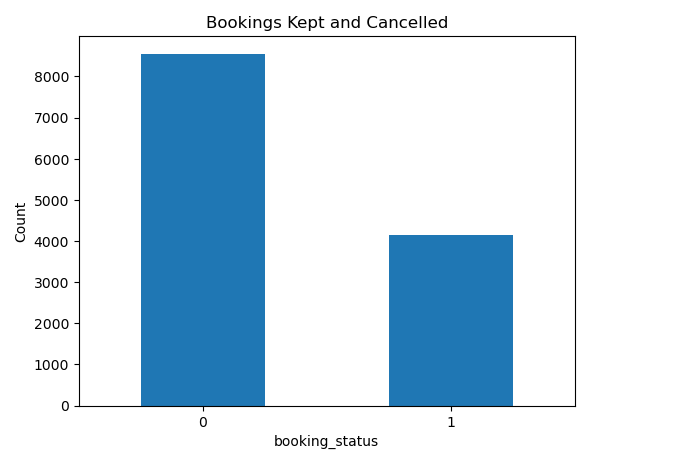

In [36]:
Image("booking_status.png")

Looking further at the data with a handy tool called [Pandas Profiling](https://github.com/ydataai/ydata-profiling), I generated a nice report that tells me a lot of stuff about the dataset such as information about the specific values in the various columns, and the probable datatypes for each of the columns (some double-checking with the Kaggle page was needed). I checked that there weren't any rows in the dataset that were missing values for columns, then took a look at the heatmap it generated (as showed below) for possible correlations between different columns. I took note of some of the darker blue squares like the one for repeated_guest and no_of_previous_bookings_not_canceled and the one for lead_time and booking_status.

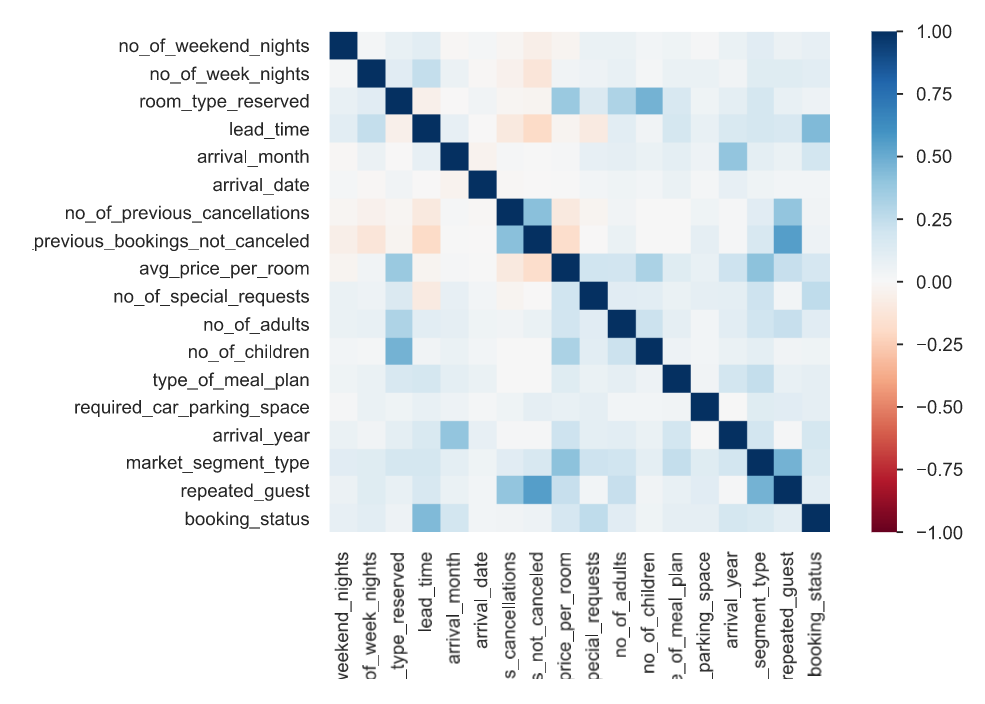

In [37]:
Image("heatmap.png")

Speaking of lead_time and booking_status, since the latter is what we want our model to predict, I decided to take a closer look at this particular relationship. I created the following histogram based on the lead_time a.k.a. the amount of time leading up to the day of the booking, with the values separated between canceled and non-canceled bookings.

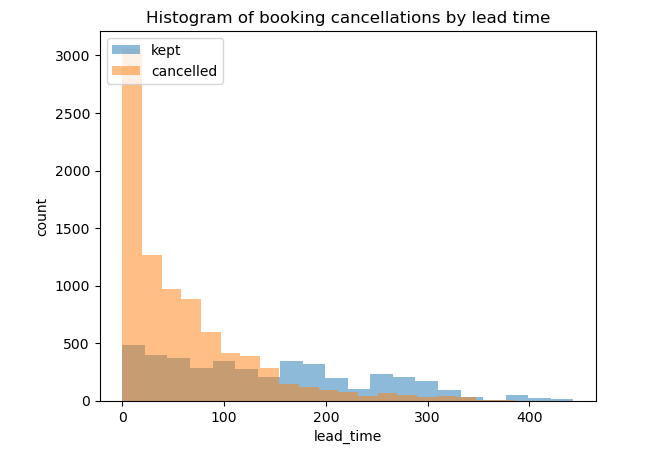

In [38]:
Image("lead_hist.png")

As you can see from the histogram above, a lot of the cancellations were happening for bookings with less lead time while the kept bookings were fairly steady until it goes down past 300 days.

Now I went about transforming the data. This involves scaling the numeric columns to make sure features with larger numbers don't drown out any relevant, but smaller-scaled features, then encoding categorical columns like months and types. Technically, the columns with categorical values were recorded as numbers in the dataset, but they represent categories rather than quantities. 


## The Model
In machine learning, there are a myriad of models to use (I'm sure that panicked anyone who faces decision paralysis) but for this assignment I'm mostly sticking to the basic ones that come with scikit-learn*. Initially, I started with a dumb model. It's not doing much thinking, just follows the mainstream by picking whatever is the most popular answer every time. Then I graded it and took a good look at its scores. So now I have a baseline, the very least I need to achieve with my serious models, if any of the models I work on after this score worse, I *definitely* know I did something wrong.

Anyway, what follows is the part of machine learning most people didn't expect: the long and tedious hours (maybe an exaggeration, maybe not depending on how potato your PC is) of running tests. Every model has these things called hyperparameters that we can tweak around with until we think everything's...well good enough. It's kind of like doing character customization in a video game, lots of options for changing the model, except, it takes a while to see the results in machine learning. 

After turning my PC into a heater for a while, I ended up going with the RandomForestClassifier which, true to its name, uses a lot of decisions trees (think of flow charts) to predict the results. One of those hyperparameters I mentioned before is the number of trees. The best option I tried was 700, which seems kinda high for me but what do I know? 
It got me a score of about 82.82% when I tested it out, so it looked like it was doing a pretty good job at guessing when a person would cancel their hotel reservations. 

## The Catch
As always with machine learning, we need take the results with some skepticism.

There were a bunch of models I've tried, but I ended up only testing hyperparameters with the RandomForestClassifier. I mentioned before that I mostly used scikit-learn's models, but there was another, [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html). Since it was different from the others, I wasn't as confident about it. That, coupled with a horrendous week where I got kicked around by a fever, left me rushing through this assignment. XGBClassifier might have been a better choice if I had run through some hyperparameters for it. On a similar vein, there's a few different methods of tweaking with hyperparameters, but I ended up using only the most basic, GridSearch, due to my time constraints.

Secondly, there were a lot of interesting things I noticed while I was exploring the data at the start, but I didn't have the time or will power to use that knowledge as well as I could have and select the important columns. 

Lastly, the dataset itself seems to be pretty recent, but I can't seem to find if most of the data is from a particular country/countries. Also, we should consider if the data is skewed towards places that allow access to the data vs places that opted not to share.

<br><br>

### Exercise 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

I liked how I introduced the concept of a baseline by using a (hopefully) funny analogy for the DummyClassifer. I tried to get down the idea behind getting a baseline from bottom up.

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

My biggest takeaway from this course is how much work goes into preprocessing the data! Before I started this semester, I had never considered the ways data needs to be transformed.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 

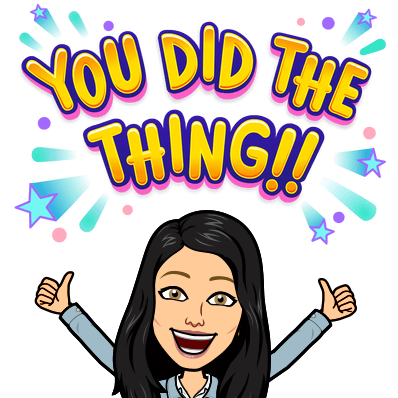

In [39]:
from IPython.display import Image

Image("eva-congrats.png")